In [1]:
import numpy as np
import pickle
from pathlib import Path
import pandas as pd
from scipy.stats import chi2
from matplotlib import pyplot as plt

In [2]:
calval_dir = Path.cwd()/'calval'
calval_location = 'central_valley'
work_dir = calval_dir/calval_location

In [3]:
with open(work_dir/'approach2.pkl','rb') as f:
    dist,rel_measure, ifgs_date = pickle.load(f)

In [4]:
n_ifgs = len(dist)

In [5]:
n_bins = 10
bins = np.linspace(0.1,50.0,num=n_bins+1)
bins_interval = bins[1]-bins[0]
bins_center = bins[:-1]+bins_interval/2

In every bin, each data point is treated as sample of normal distribution $N(0,\sigma)$, so this is a interval estimation problem. The point estimation of $\sigma^2$ is
$$\frac{\sum_1^n x_i^2}{n}$$
In essence, this point estimation can be seen as emperical semivariogram since semivariogram is defined as
$$E(f(x)-f(x-r))^2$$
The confidence lower-bound is
$$\frac{\sum_1^n x_i^2}{\chi_n^2(1-\alpha)}$$
where $x$ is the sample, $1-\alpha$ is the confidence level.
If the confidence lower-bound is larger than $(3(1+L^{1/2}))^2$, we can say we have at least $1-\alpha$'s confidence to say the real $\sigma$ is larger than the $(3(1+L^{1/2}))^2$.
https://faculty.elgin.edu/dkernler/statistics/ch09/9-3.html is a reference of the statistics method used here.

This lower-bound can be also understanded in the hypothetical test's manner.
We define null hypotheis as $\sigma^2 <= \sigma_0^2 $. $\sigma_0^2$ is the value by the requirement curve. We will reject this null hypotheis if the samples show this hypotheis is wrong with great confidence.

The test is defined as: If $\sum_1^n x_i^2 > C$, we reject the null hypothesis.

By statistical analysis, if we define $C = \chi_n^2(1-\alpha)\sigma_0^2$, the significance level is equal to $1-\alpha$.

In [6]:
alpha = 0.05

In [7]:
n_all = np.empty([n_ifgs,n_bins+1],dtype=int) # number of points for each ifgs and bins
lowbound = np.empty([n_ifgs,n_bins])
est = np.empty([n_ifgs,n_bins])
rqmt = (3*(1+np.sqrt(bins_center)))**2 # square of the curve
for i in range(n_ifgs):
    inds = np.digitize(dist[i],bins)
    for j in range(1,n_bins+1):
        rem = rel_measure[i][inds==j] # relative measurement for each bin
        len_rem = len(rem)
        n_all[i,j-1] = len_rem
        lowbound[i,j-1] = sum(rem**2)/chi2.ppf(1-alpha,df=len_rem)
        est[i,j-1] = sum(rem**2)/len_rem
        
    n_all[i,-1] = np.sum(n_all[i,0:-2])

In [8]:
def to_str(x:bool):
    if x==True:
        return 'true '
    elif x==False:
        return 'false '

<ipython-input-9-a86890c942ea>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=[18, 5.5])


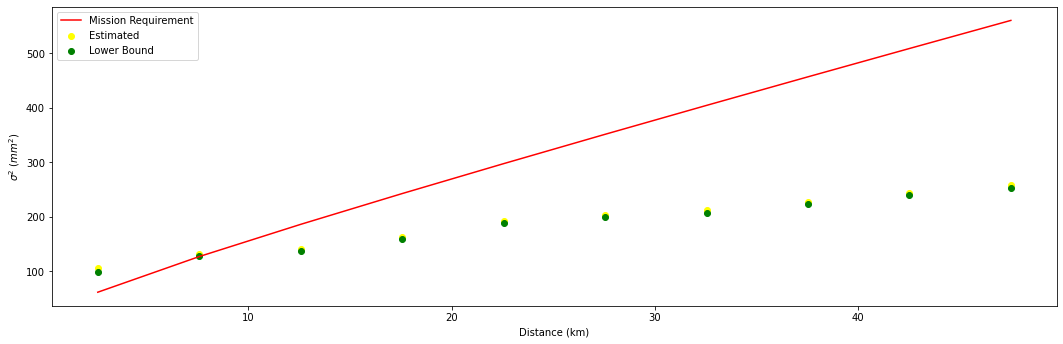

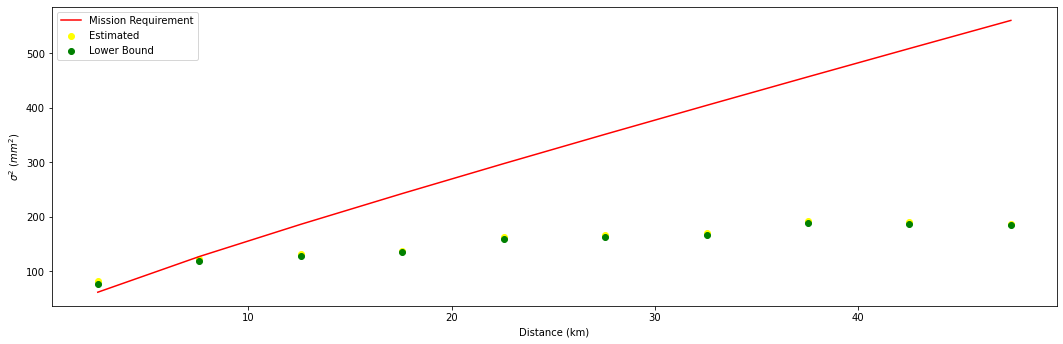

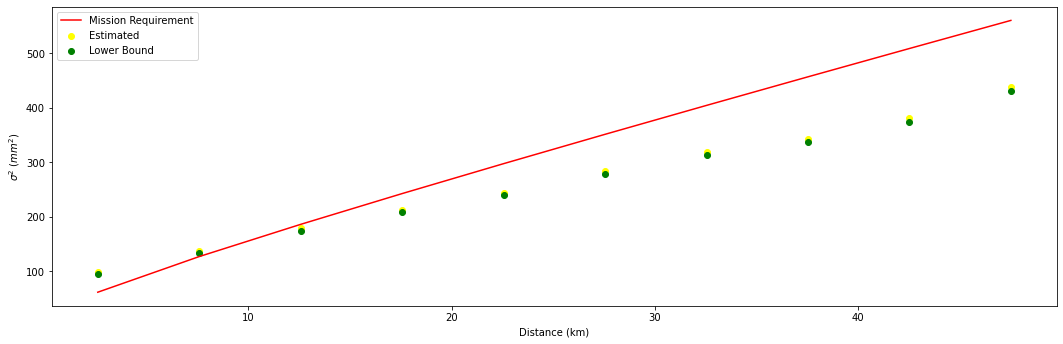

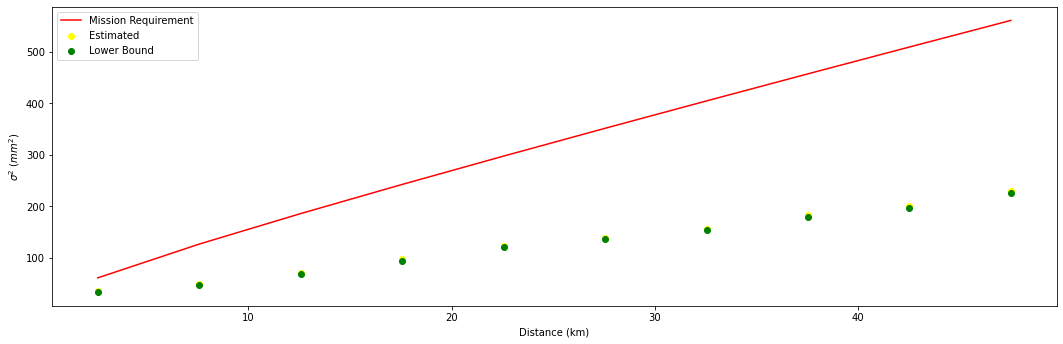

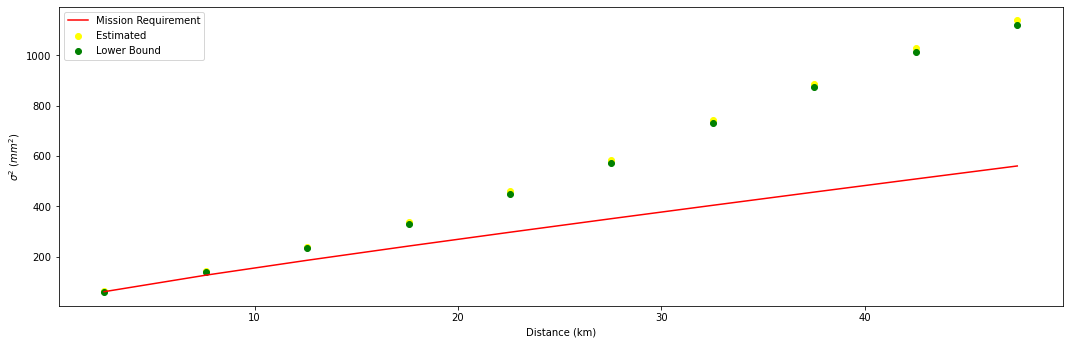

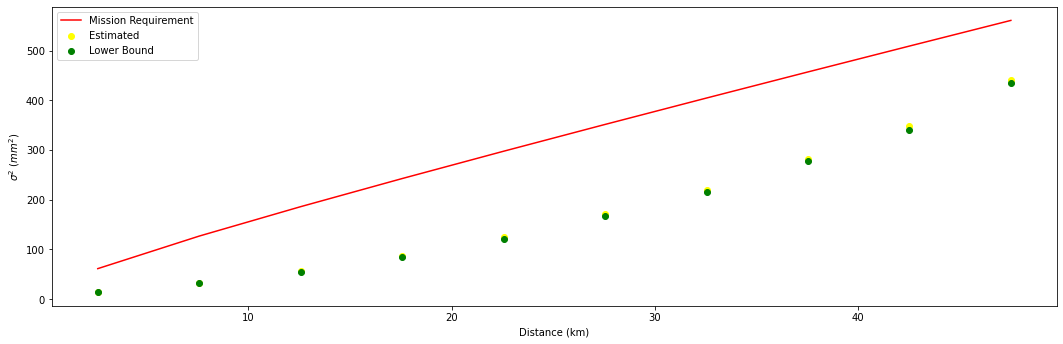

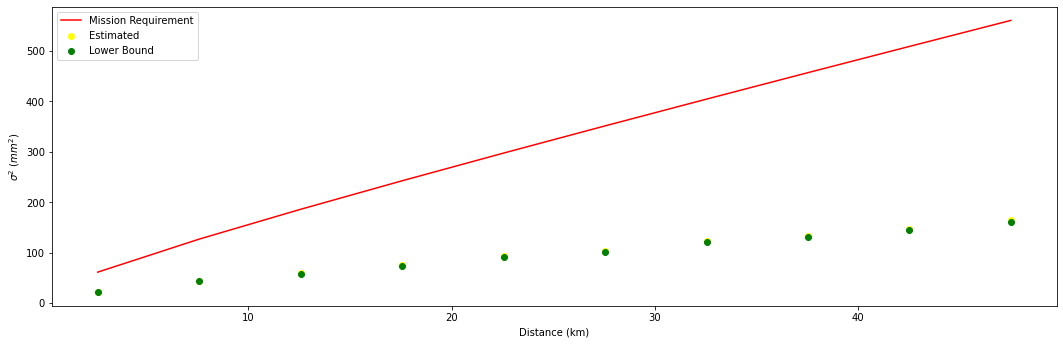

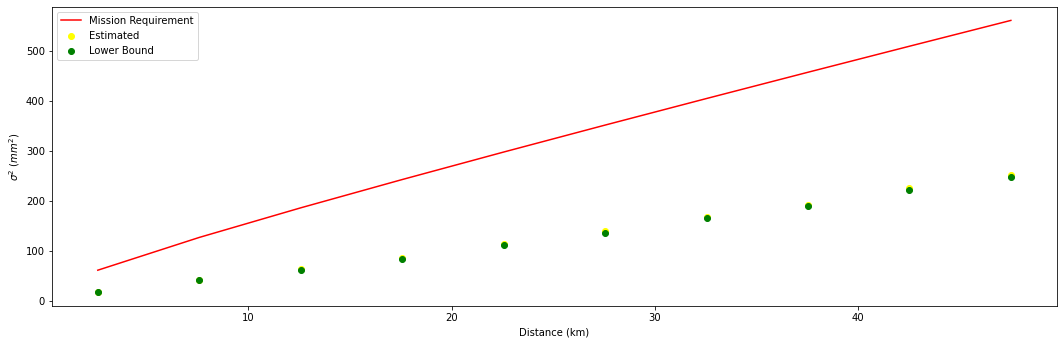

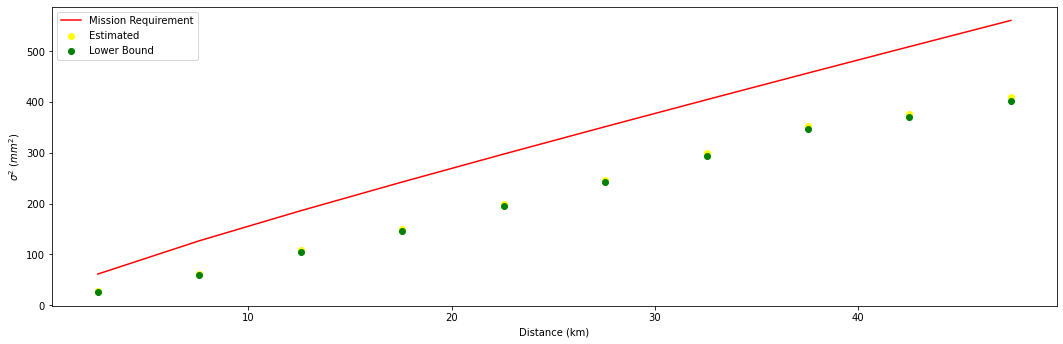

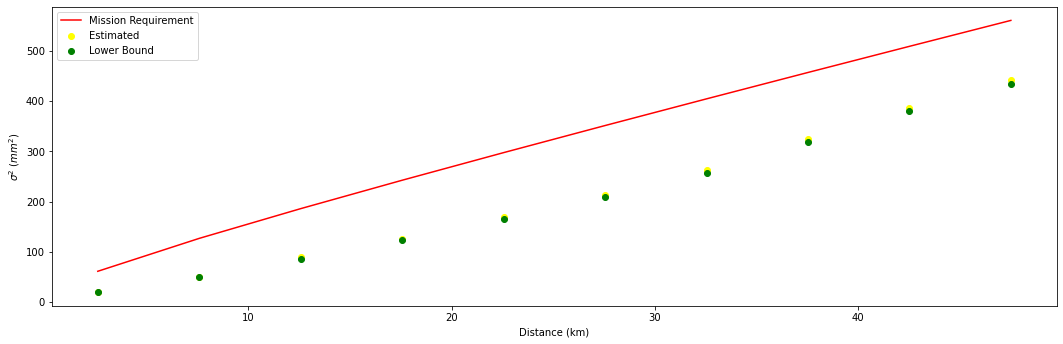

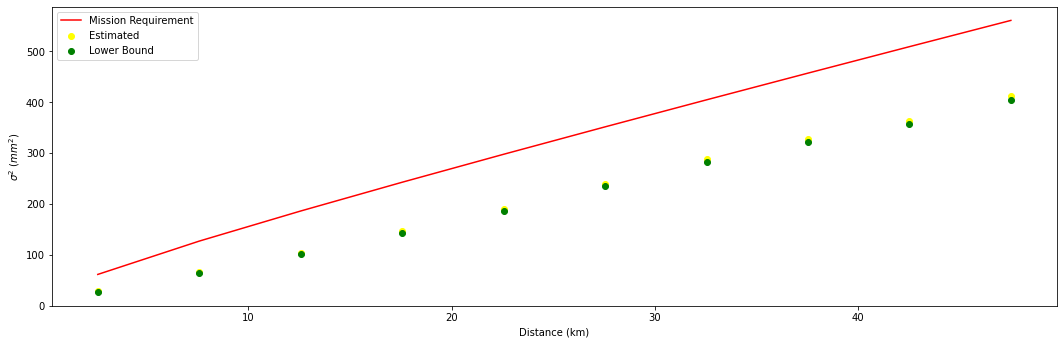

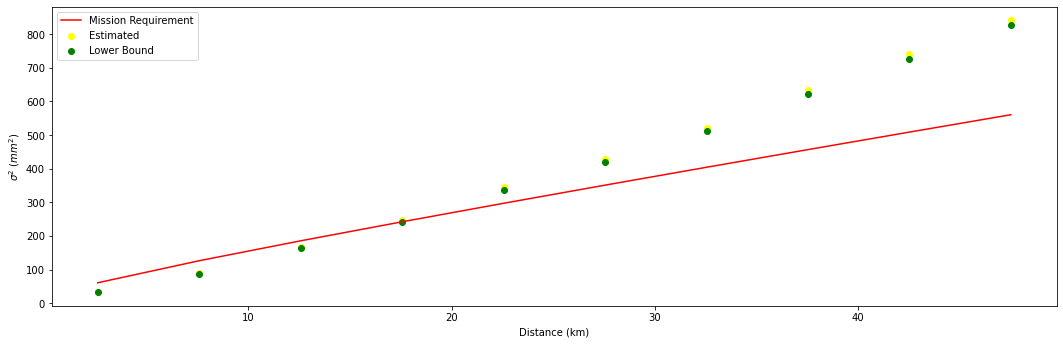

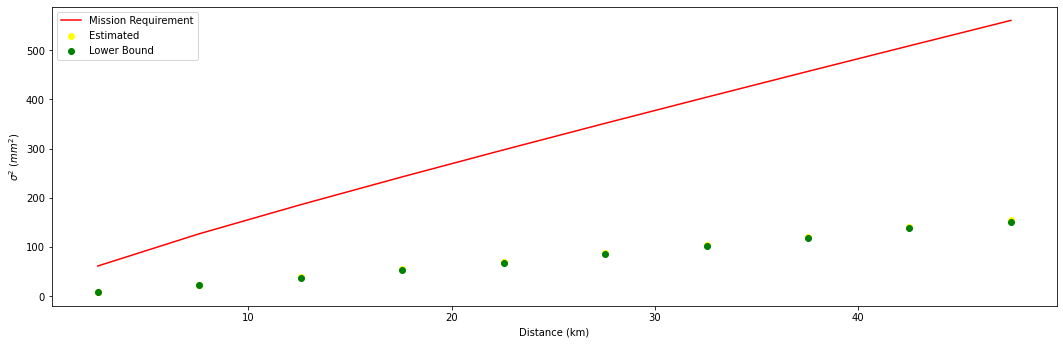

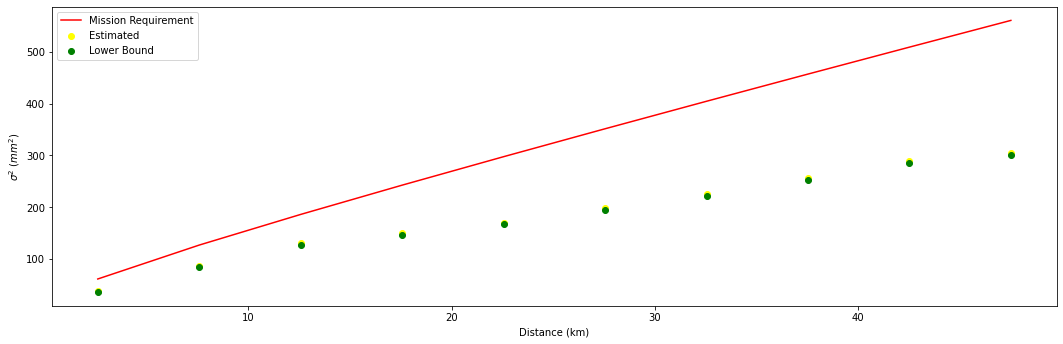

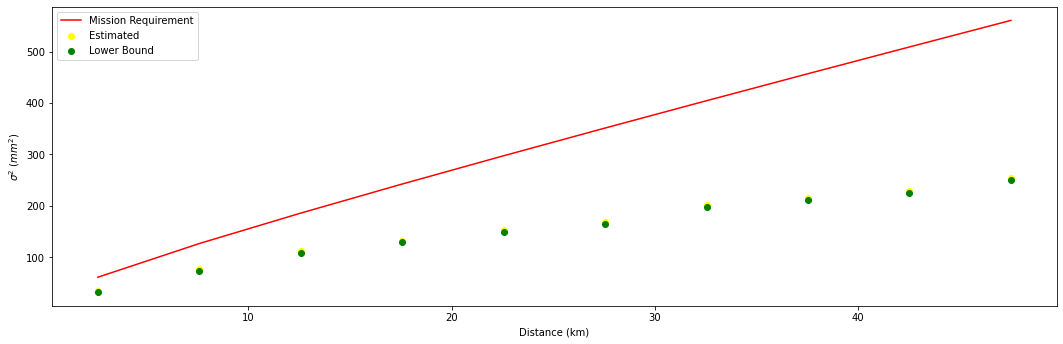

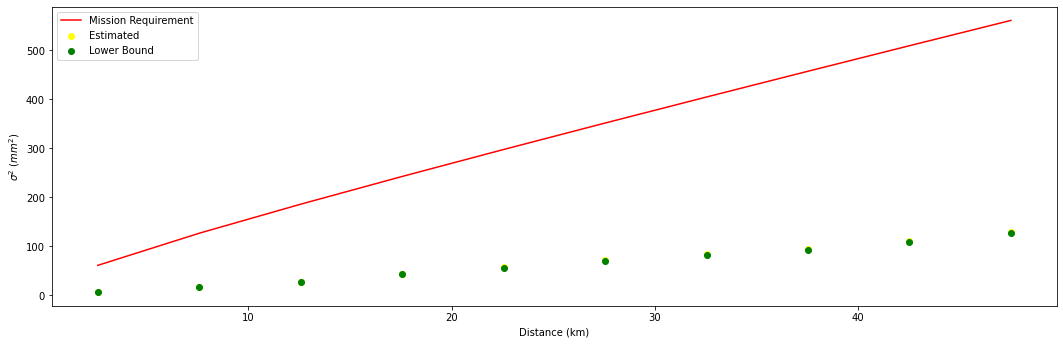

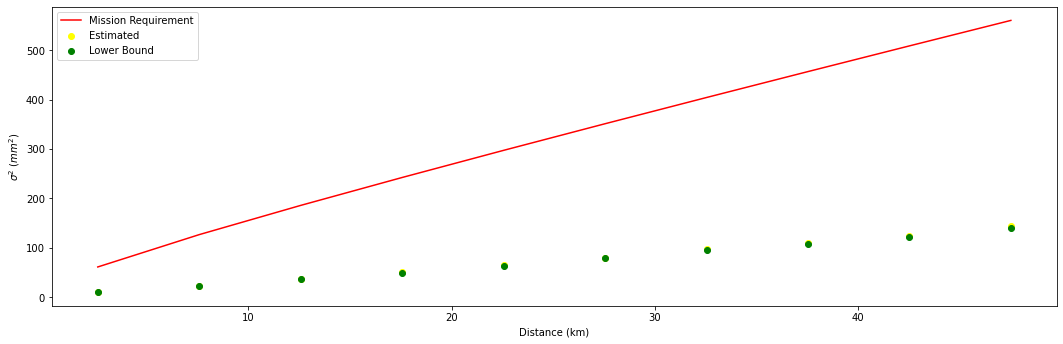

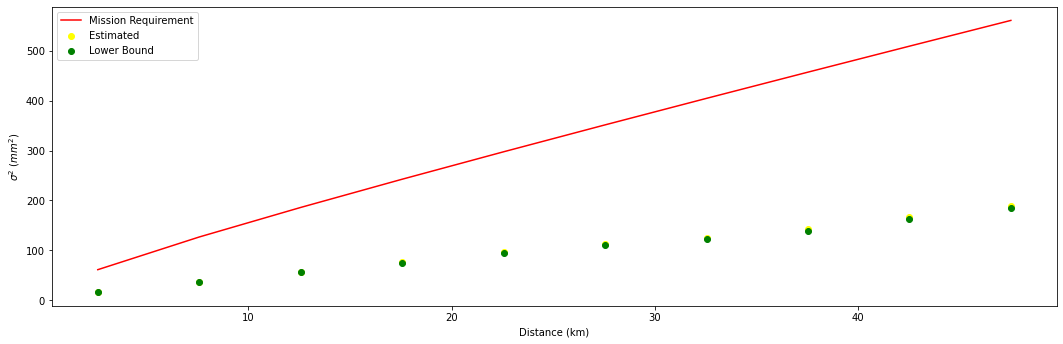

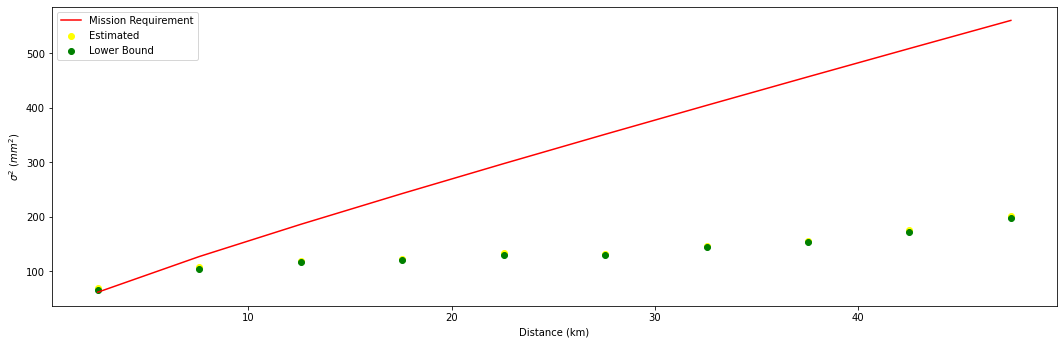

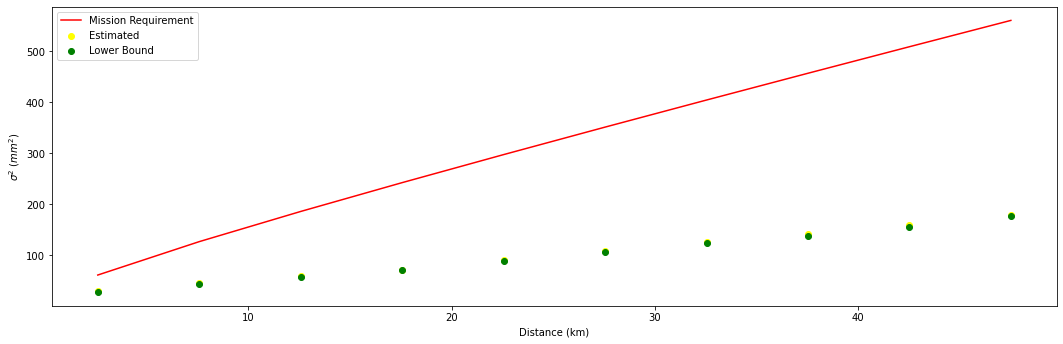

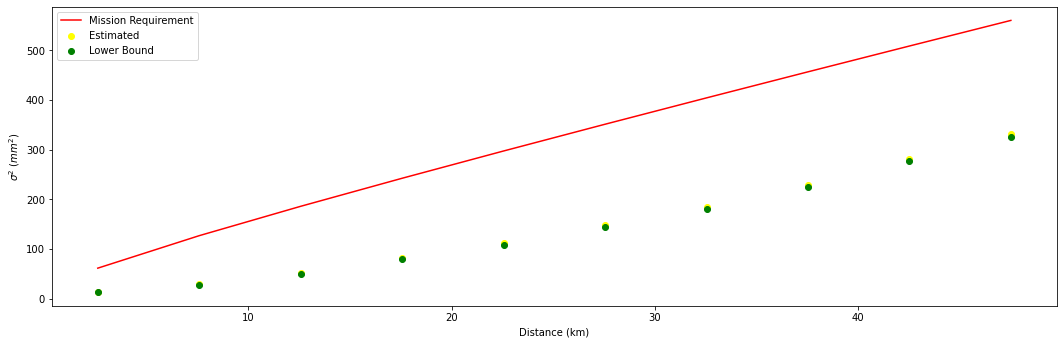

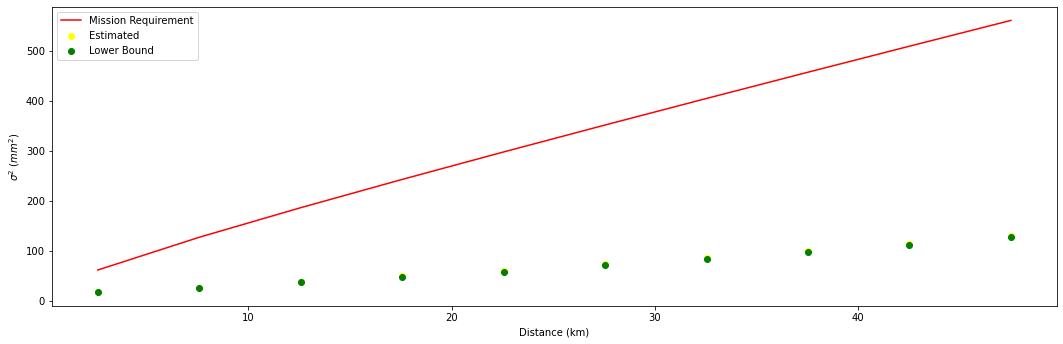

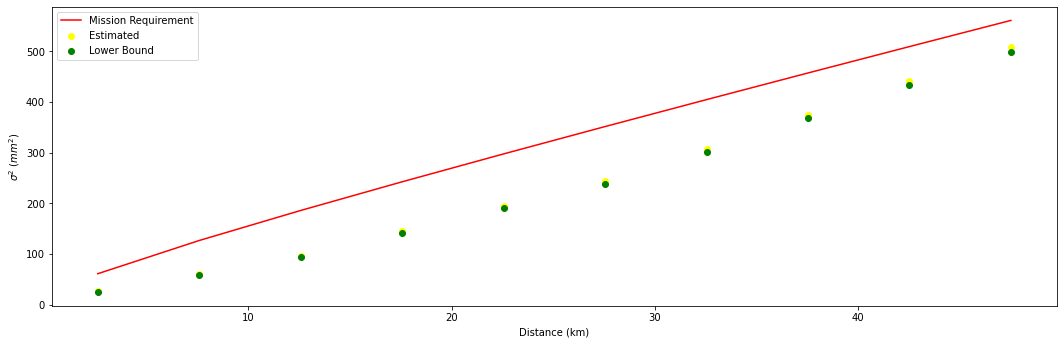

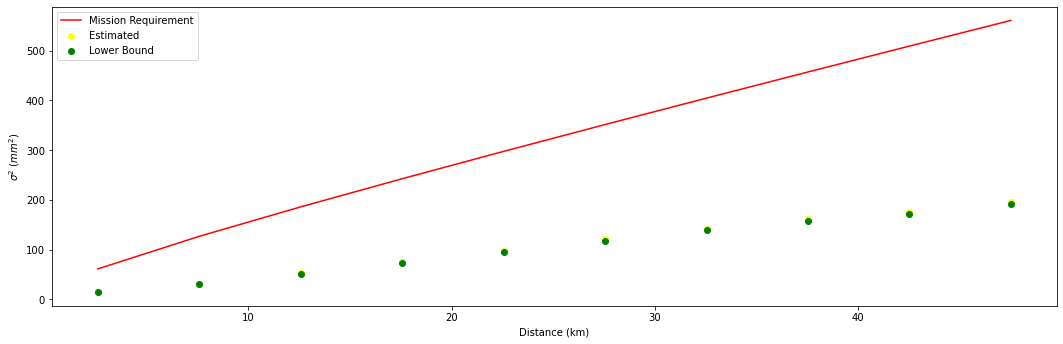

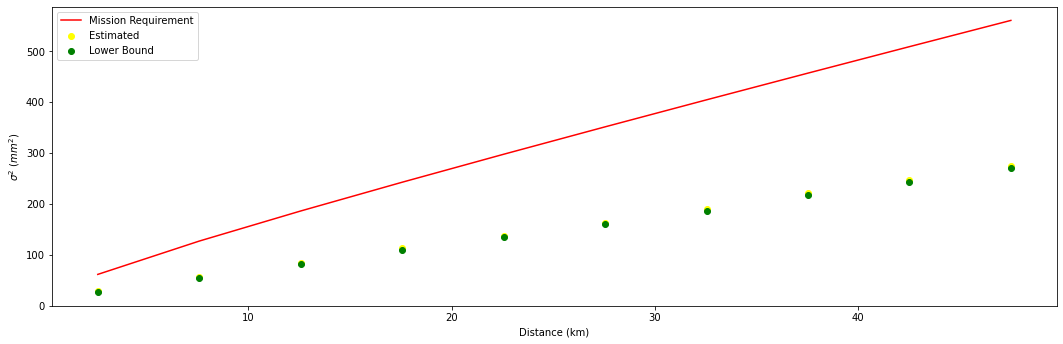

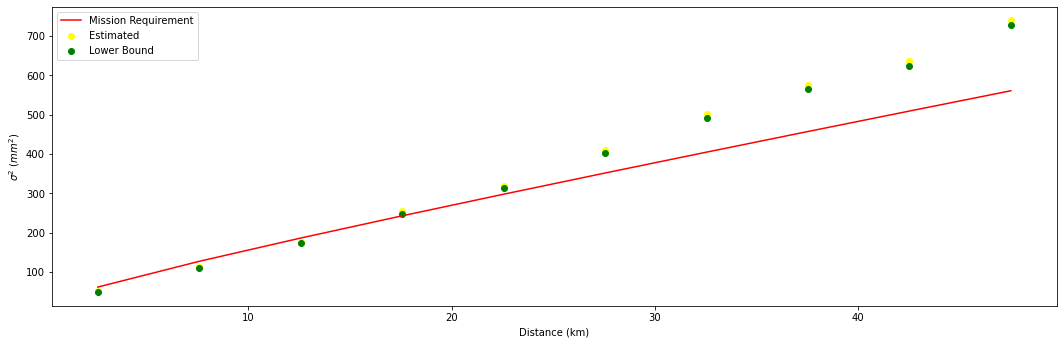

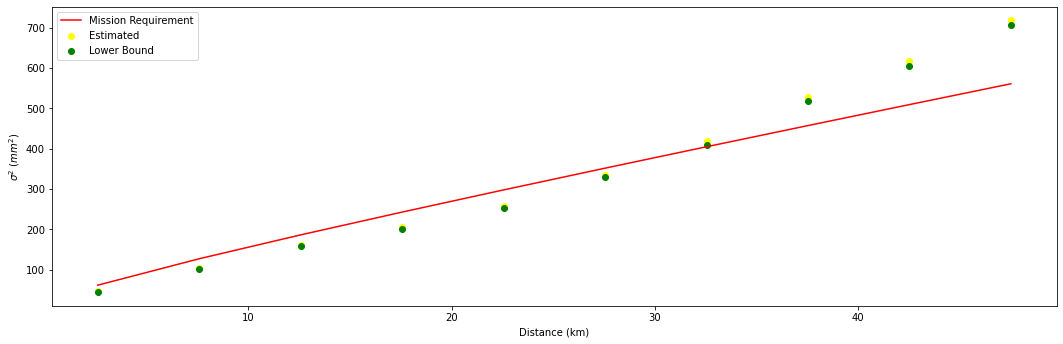

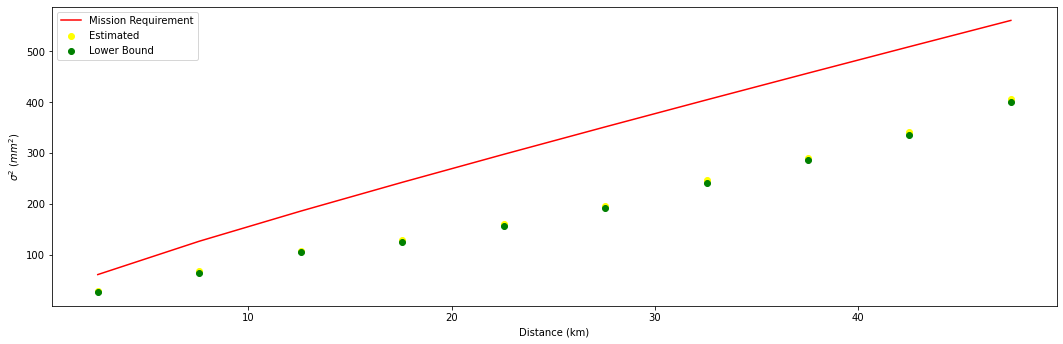

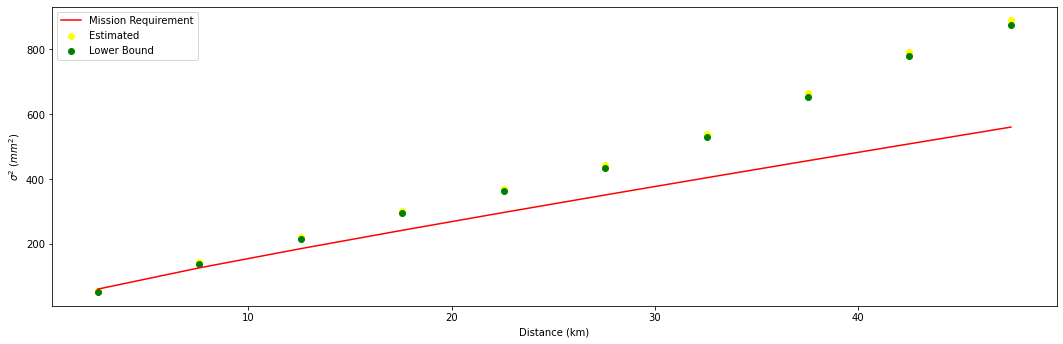

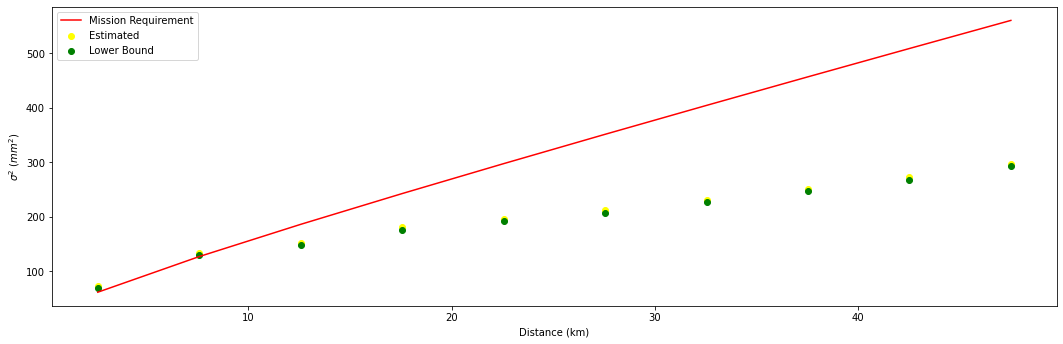

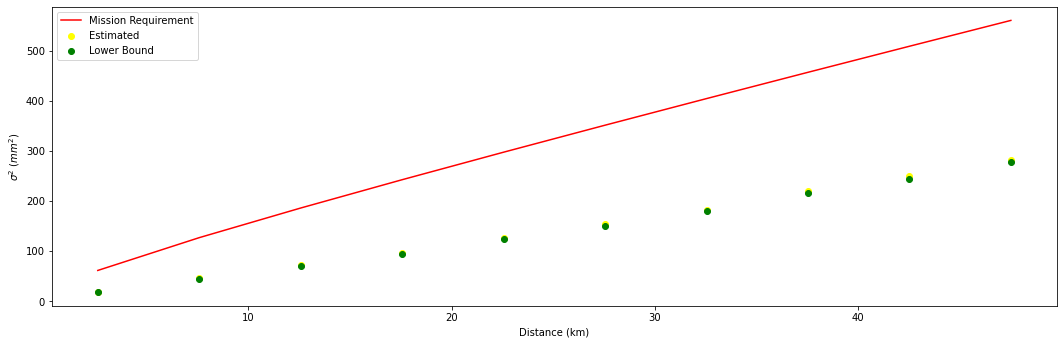

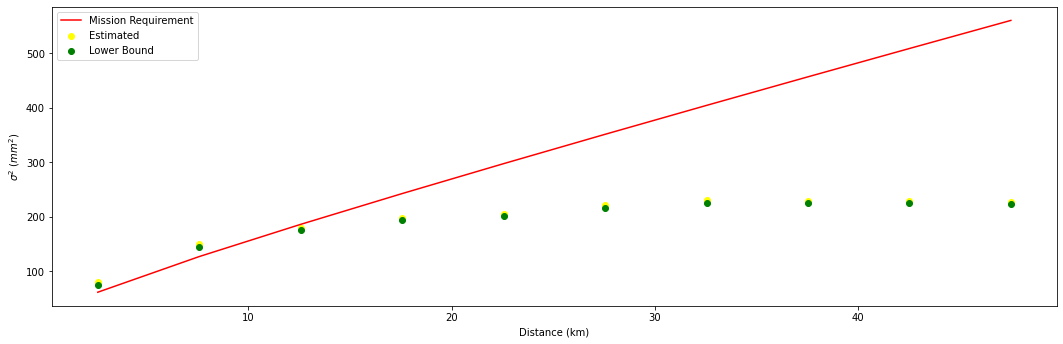

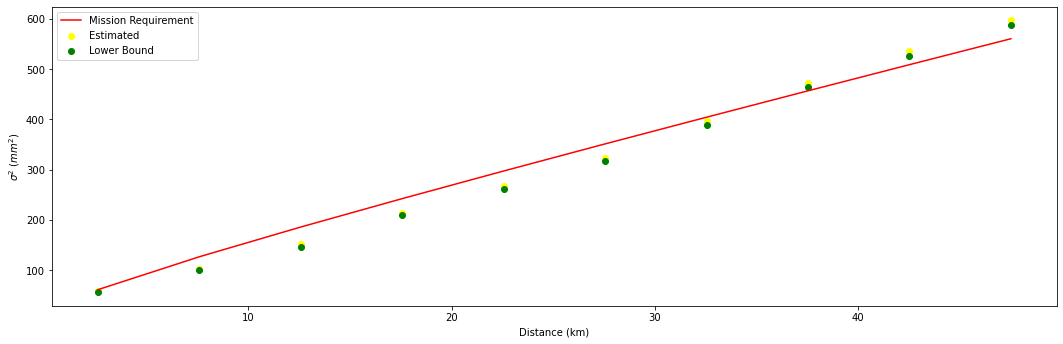

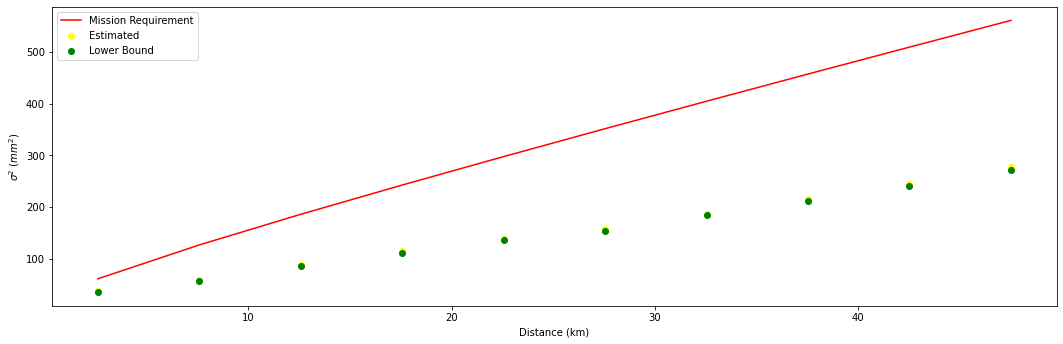

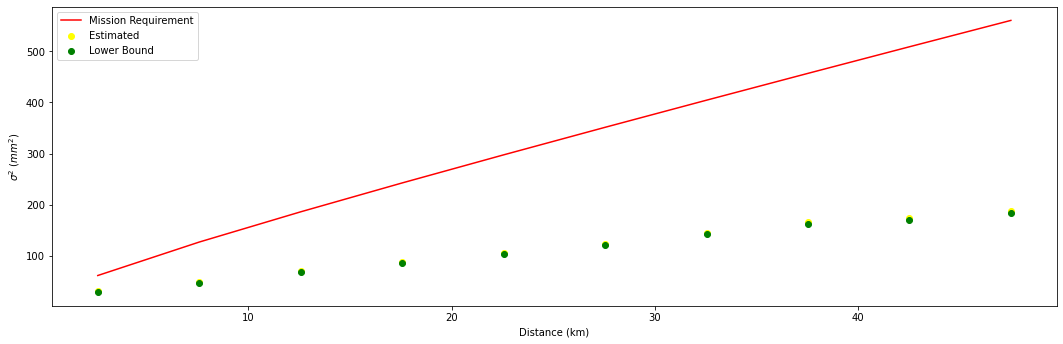

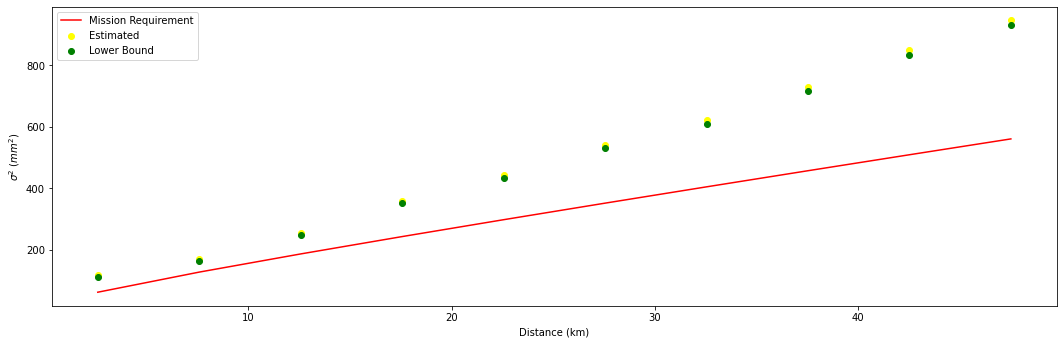

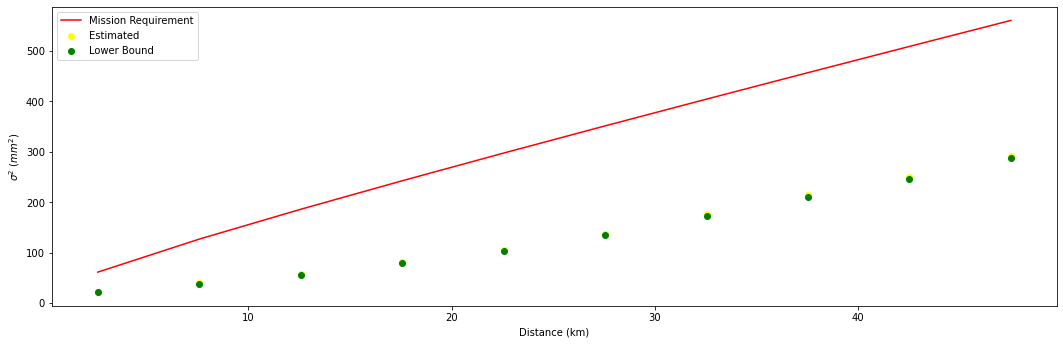

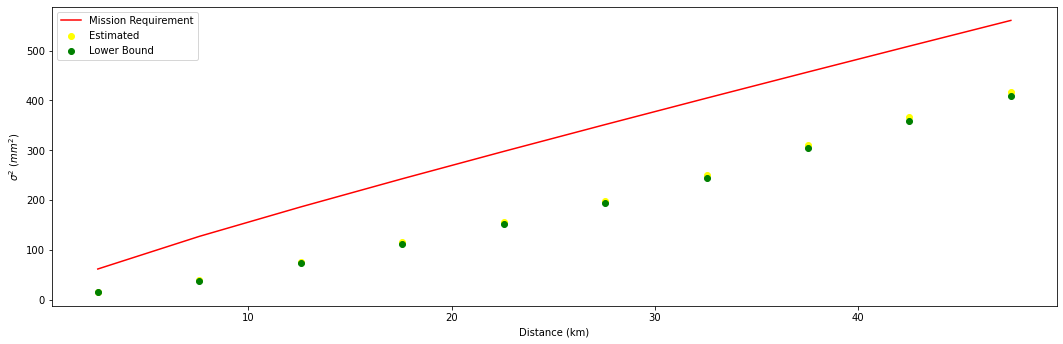

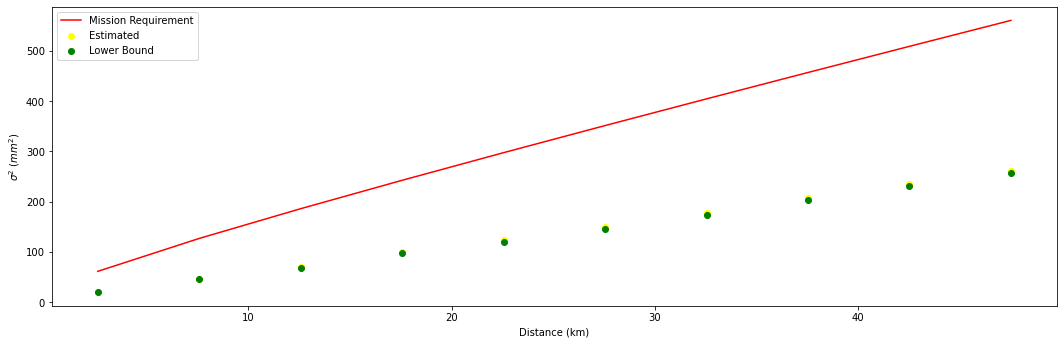

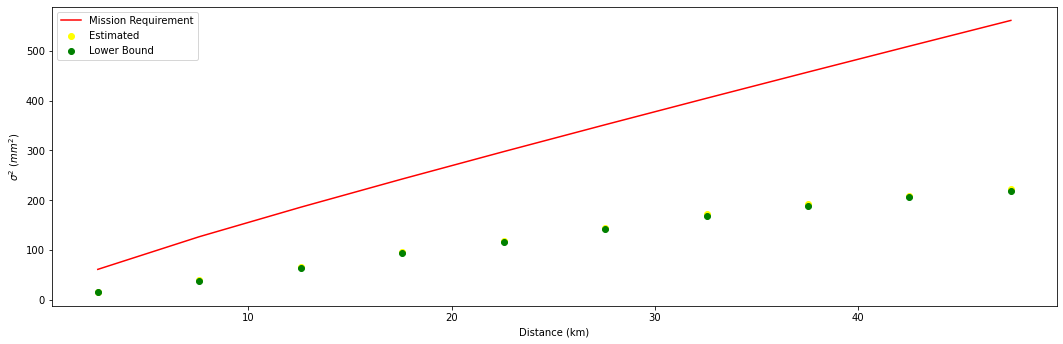

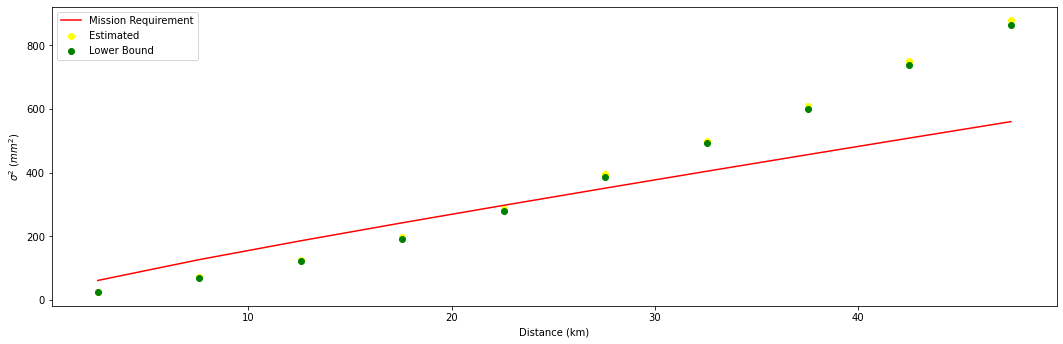

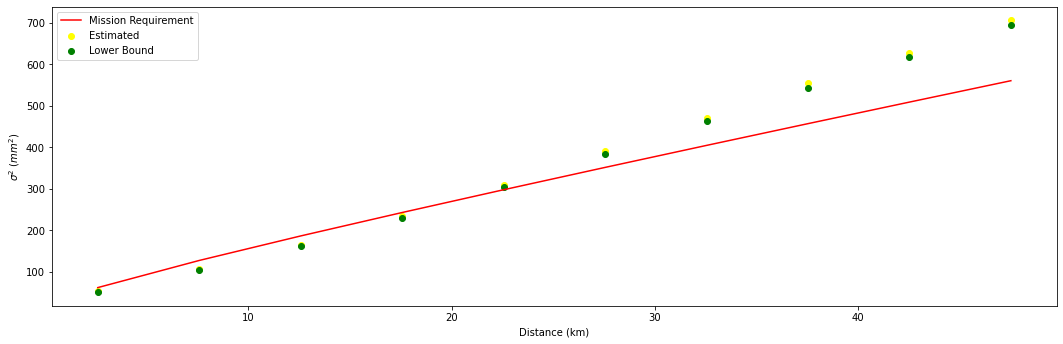

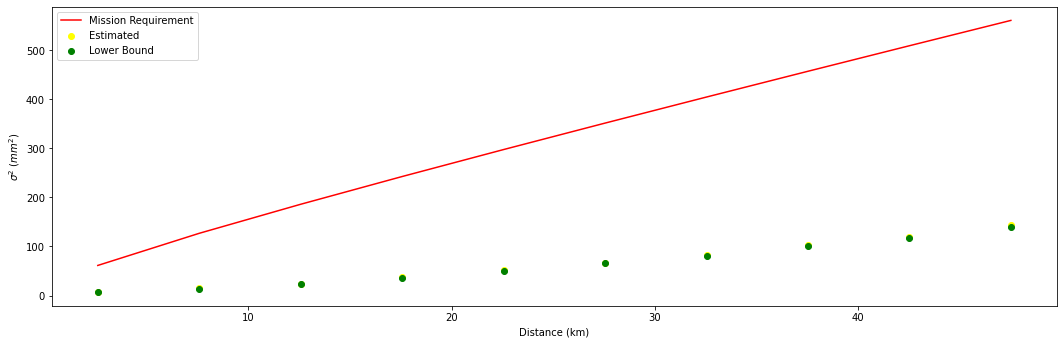

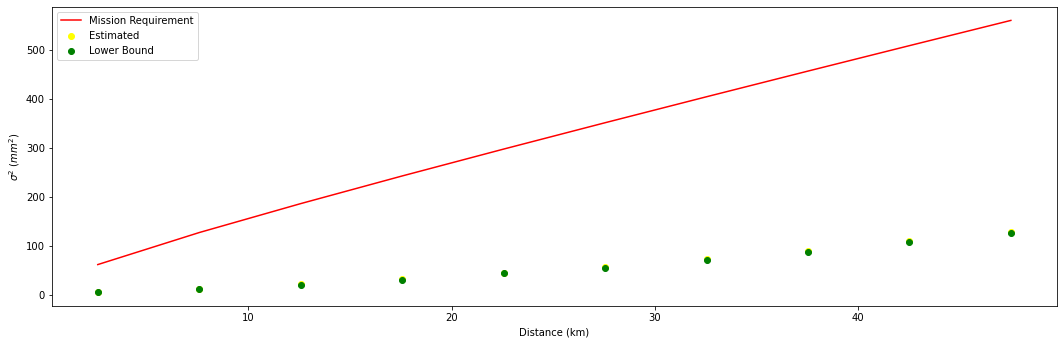

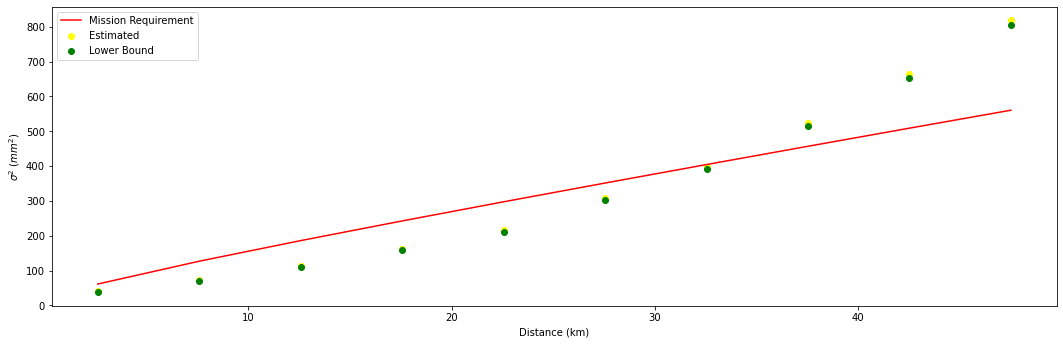

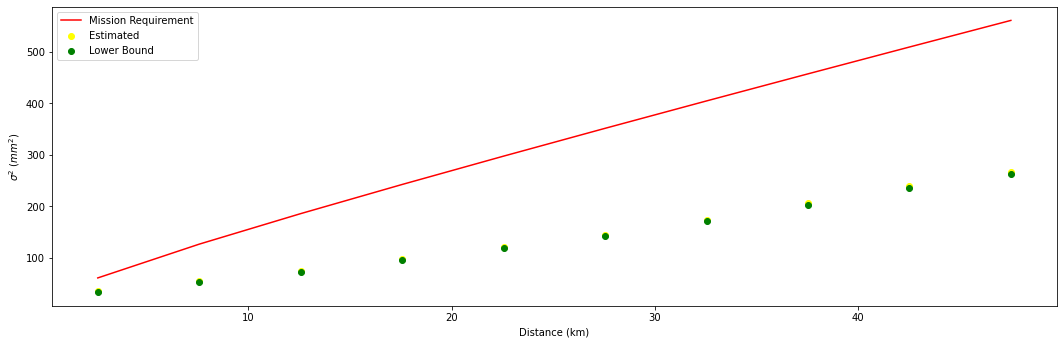

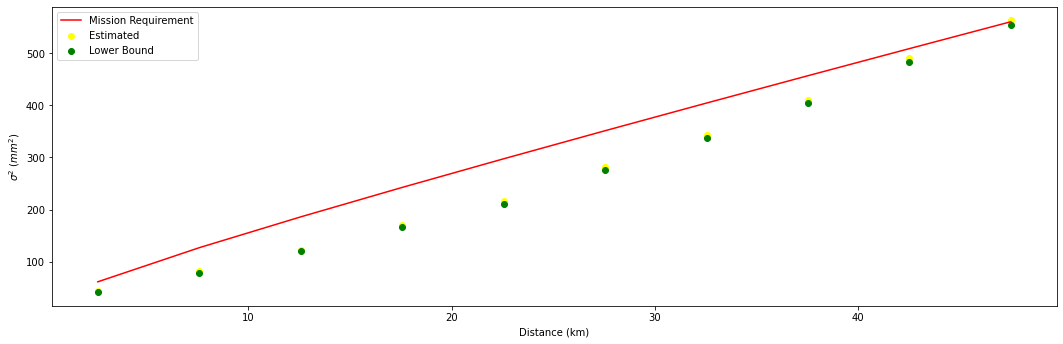

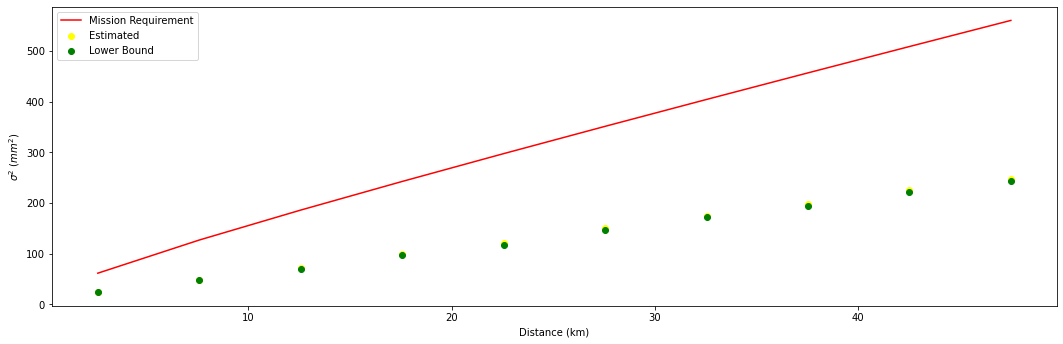

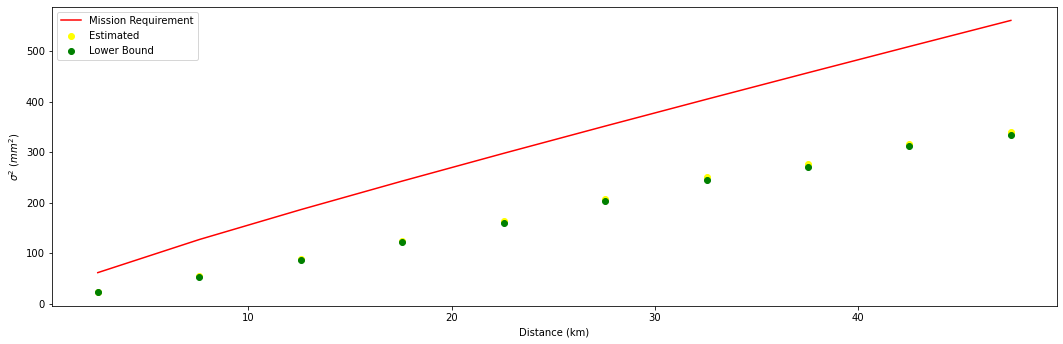

In [9]:
for i in range(n_ifgs):
    fig, ax = plt.subplots(figsize=[18, 5.5])
    ax.plot(bins_center,rqmt,'r')
    ax.scatter(bins_center,est[i],c='yellow')
    ax.scatter(bins_center,lowbound[i],c='green')

    ax.set_xlabel('Distance (km)')
    ax.set_ylabel(r'$\sigma^2$ ($mm^2$)')
    plt.legend(["Mission Requirement","Estimated","Lower Bound"])

In [10]:
success_or_fail = lowbound<rqmt
success_or_fail_total = success_or_fail.prod(axis=1,dtype=bool)
success_or_fail_total_2d = np.array([success_or_fail_total])
success_or_fail = np.hstack((success_or_fail,success_or_fail_total_2d.T))
success_or_fail_str = [list(map(to_str, x)) for x in success_or_fail]

In [11]:
columns = []
for i in range(n_bins):
    columns.append(f'{bins[i]:.2f}-{bins[i+1]:.2f}')
columns.append('total')

In [12]:
index = []
for i in range(len(ifgs_date)):
    index.append(ifgs_date[i,0].strftime('%Y%m%d')+'-'+ifgs_date[i,1].strftime('%Y%m%d'))

In [13]:
n_all_pd = pd.DataFrame(n_all,columns=columns,index=index)
success_or_fail_pd = pd.DataFrame(success_or_fail_str,columns=columns,index=index)

In [14]:
s = n_all_pd.style
s.set_table_styles([  # create internal CSS classes
    {'selector': '.true', 'props': 'background-color: #e6ffe6;'},
    {'selector': '.false', 'props': 'background-color: #ffe6e6;'},
], overwrite=False)
s.set_td_classes(success_or_fail_pd)

,0.10-5.09,5.09-10.08,10.08-15.07,15.07-20.06,20.06-25.05,25.05-30.04,30.04-35.03,35.03-40.02,40.02-45.01,45.01-50.00,total
20170108-20170120,1663,4694,7147,9436,11369,12927,14437,15641,16698,17631,94012
20170114-20170126,1653,4708,7320,9687,11772,13624,15118,16530,17736,18445,98148
20170120-20170201,1646,4639,7422,9929,11897,13650,15121,16296,17399,18409,97999
20170225-20170309,1707,4694,7268,9574,11579,13501,15354,16399,17562,18378,97638
20170321-20170402,1634,4578,7333,9658,11807,13387,15219,16519,17508,18082,97643
20170414-20170426,1634,4654,7167,9442,11587,13245,14745,16078,17093,18083,95645
20170508-20170520,1658,4622,7371,9633,11703,13352,14866,15918,17360,18420,96483
20170601-20170613,1674,4642,7221,9541,11633,13715,15117,16636,17658,18373,97837
20170625-20170707,1674,4571,7097,9498,11373,13524,14786,15927,17175,18069,95625
20170719-20170731,1708,4722,7395,9772,11995,14183,15693,16915,18098,18909,100481


Percentage of interferograms passes the requirement (significant level = 0.95):

In [15]:
np.count_nonzero(success_or_fail_total)/len(success_or_fail_total)

0.673469387755102